In [1]:
import notebook_import
import arrhythmia.experimental.mitdb as mitdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Using TensorFlow backend.


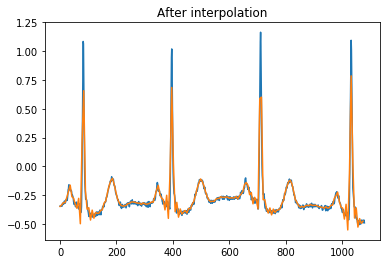

Unique label sets and their count:
[0. 0. 0.] 703
[0. 1. 0.] 565
[0. 1. 1.] 114
[1. 0. 0.] 312
[1. 0. 1.] 2
[1. 1. 0.] 228
[1. 1. 1.] 144
Total of 2068 samples


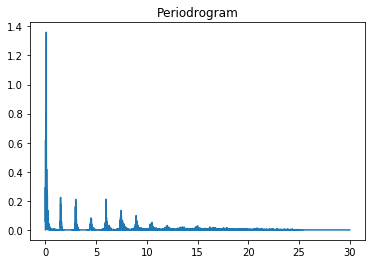

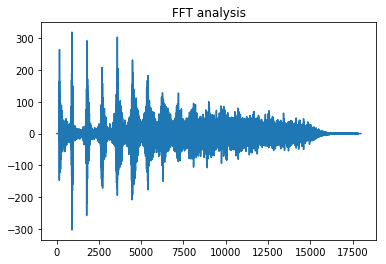

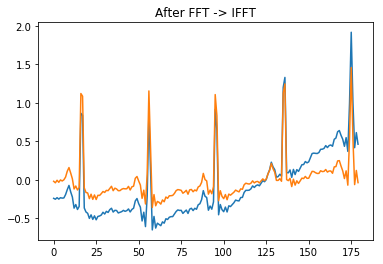

In [2]:
# Load all mitdb records
full_data = mitdb.get_records(mitdb.full_ds)

# Slice all data into time frames of size 10 min + 5 min
from arrhythmia.experimental.common import slice_records
from arrhythmia.model.helpers import beat_types
from arrhythmia.model.preprocessing import downsample

pred_minutes = 5
post_minutes = 2

pred_window = 360 * 60 * pred_minutes
post_window = 360 * 60 * post_minutes

slicer = slice_records(full_data, pred_window, post_window, increment=360 * 30, check_pred=False)

# Convert loaded data into model input and expected classes
def to_classes(labels, threshold=1):
    targets = np.zeros(len(beat_types[1:-1]), dtype=np.float32)
    for i, bt in enumerate(beat_types[1:-1]):
        count = np.sum(labels == bt.symbol)
        targets[i] = 1.0 if count >= threshold else 0.0
    return targets

# Downsample data to reduce number of features and remove high f. noise at the same time
frequency = 360
target_frequency = 60
input_data = []
classes = []
for i, (pred, post) in enumerate(slicer):
    data = pred[0]
    cl = to_classes(post[2])
    if target_frequency != frequency:
        if i == 0:
            plt.plot(data[:frequency*3])
        data = downsample(data, frequency // target_frequency)
        if i == 0:
            back_x = np.arange(0, frequency*3, frequency // target_frequency)
            plt.plot(back_x, data[:target_frequency*3])
            plt.title('After interpolation')
            plt.show()

    input_data.append(data)
    classes.append(cl)

frequency = target_frequency
        
input_data = np.array(input_data)
classes = np.array(classes)
        
unique, cnts = np.unique(classes, axis=0, return_counts=True)
print('Unique label sets and their count:')
for u, c in zip(unique, cnts):
    print(u, c)
print('Total of {} samples'.format(sum(cnts)))

# Plot periodogram
periodogram = True
if periodogram:
    from scipy.signal import periodogram
    f, pxx = periodogram(input_data[-2], frequency, return_onesided=True)
    plt.plot(f, pxx)
    plt.title('Periodrogram')
    plt.show()

# Remove low frequency noise using FFT->IFFT
fft = True
replace_with_fft = False
fft_threshold = 0.5
if fft:
    from scipy import fftpack
    after_fft = fftpack.rfft(input_data)

    fft_freq = fftpack.fftfreq(after_fft.shape[-1], d=1/frequency)

    after_fft[:, np.abs(fft_freq) < fft_threshold] = 0
    plt.plot(after_fft[-2].real)
    plt.title('FFT analysis')
    plt.show()
    
    if not replace_with_fft:
        plt.plot(input_data[-2][:frequency*3])
        input_data = fftpack.irfft(after_fft)
        plt.plot(input_data[-2][:frequency*3])
        plt.title('After FFT -> IFFT')
        plt.show()
    else:
        input_data = fft_freq.real

input_data = np.array(input_data)
input_shape = input_data.shape[1:]

# Normalize input data
from arrhythmia.experimental.common import normalize_mean_std

input_data_n = normalize_mean_std(input_data)

In [3]:
from arrhythmia.experimental.common import ModelTester
import keras.backend as K
# TODO Update keras to use those metrics
#from keras.metrics import precision, recall

tester = ModelTester(input_data_n, classes, verbose=0)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

metrics = ['binary_accuracy', 'mse', precision, recall, fmeasure]

window_postfix = str(pred_minutes) + '_' + str(post_minutes)
def network_name(name):
    return 'mlp_' + str(name) + '_window' + window_postfix + '.hdf5'

## Networks:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Conv1D, MaxPooling1D, Flatten


def simple_network(layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = inputs
        for layer in layers:
            x = Dense(layer, activation='relu')(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

def conv_network(pool=4, layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = Reshape((*input_shape, 1))(inputs)
        for size, num in layers:
            x = Conv1D(size, num, activation='relu')(x)
            x = MaxPooling1D(pool_size=pool)(x)
        x = Flatten()(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

Testing simple model with layers: [10, 50, 10]
Trained for 8 epochs
loss: 0.6260, binary_accuracy: 0.6570, mean_squared_error: 0.2135, precision: 0.4954, recall: 0.3333, fmeasure: 0.3721
Trained for 12 epochs
loss: 0.6163, binary_accuracy: 0.6554, mean_squared_error: 0.2124, precision: 0.4674, recall: 0.3025, fmeasure: 0.3491
Trained for 14 epochs
loss: 0.6126, binary_accuracy: 0.6723, mean_squared_error: 0.2096, precision: 0.4641, recall: 0.4244, fmeasure: 0.4260
Trained for 12 epochs
loss: 0.5843, binary_accuracy: 0.6812, mean_squared_error: 0.1988, precision: 0.4925, recall: 0.3192, fmeasure: 0.3704
Trained for 12 epochs
loss: 0.5683, binary_accuracy: 0.6642, mean_squared_error: 0.1960, precision: 0.3908, recall: 0.2481, fmeasure: 0.2941
loss: 0.6015 (+/-0.0216), binary_accuracy: 0.6660 (+/-0.0097), mean_squared_error: 0.2060 (+/-0.0073), precision: 0.4620 (+/-0.0378), recall: 0.3255 (+/-0.0573), fmeasure: 0.3623 (+/-0.0425)


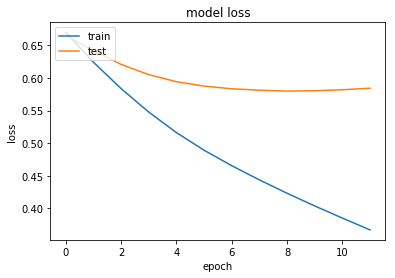

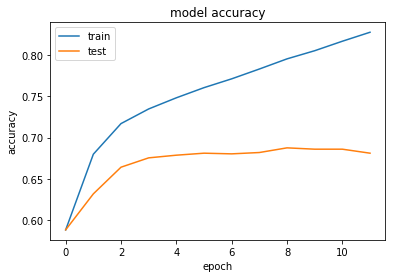

Testing simple model with layers: [100, 100]
Trained for 6 epochs
loss: 0.6086, binary_accuracy: 0.6787, mean_squared_error: 0.2040, precision: 0.4877, recall: 0.3512, fmeasure: 0.3856
Trained for 6 epochs
loss: 0.6208, binary_accuracy: 0.6795, mean_squared_error: 0.2103, precision: 0.4921, recall: 0.3573, fmeasure: 0.3916
Trained for 6 epochs
loss: 0.6020, binary_accuracy: 0.6812, mean_squared_error: 0.2044, precision: 0.4587, recall: 0.3495, fmeasure: 0.3831
Trained for 7 epochs
loss: 0.5767, binary_accuracy: 0.6925, mean_squared_error: 0.1953, precision: 0.4865, recall: 0.4110, fmeasure: 0.4292
Trained for 8 epochs
loss: 0.5791, binary_accuracy: 0.6877, mean_squared_error: 0.1980, precision: 0.4156, recall: 0.3443, fmeasure: 0.3679
loss: 0.5974 (+/-0.0171), binary_accuracy: 0.6839 (+/-0.0053), mean_squared_error: 0.2024 (+/-0.0053), precision: 0.4681 (+/-0.0288), recall: 0.3626 (+/-0.0245), fmeasure: 0.3915 (+/-0.0204)


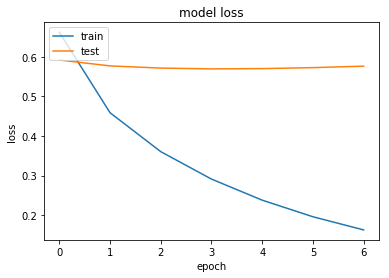

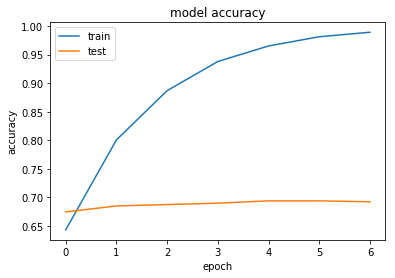

Testing simple model with layers: [100, 200, 100]
Trained for 7 epochs
loss: 0.6027, binary_accuracy: 0.6586, mean_squared_error: 0.2061, precision: 0.4788, recall: 0.2778, fmeasure: 0.3185
Trained for 7 epochs
loss: 0.5892, binary_accuracy: 0.6844, mean_squared_error: 0.2007, precision: 0.5045, recall: 0.3300, fmeasure: 0.3896
Trained for 7 epochs
loss: 0.5652, binary_accuracy: 0.6940, mean_squared_error: 0.1926, precision: 0.5063, recall: 0.3168, fmeasure: 0.3726
Trained for 8 epochs
loss: 0.5685, binary_accuracy: 0.7111, mean_squared_error: 0.1912, precision: 0.5207, recall: 0.3742, fmeasure: 0.4293
Trained for 8 epochs
loss: 0.5631, binary_accuracy: 0.6925, mean_squared_error: 0.1926, precision: 0.4271, recall: 0.3252, fmeasure: 0.3515
loss: 0.5778 (+/-0.0156), binary_accuracy: 0.6881 (+/-0.0171), mean_squared_error: 0.1967 (+/-0.0058), precision: 0.4875 (+/-0.0331), recall: 0.3248 (+/-0.0308), fmeasure: 0.3723 (+/-0.0371)


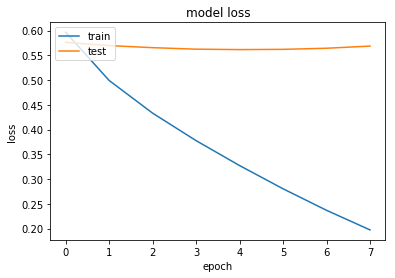

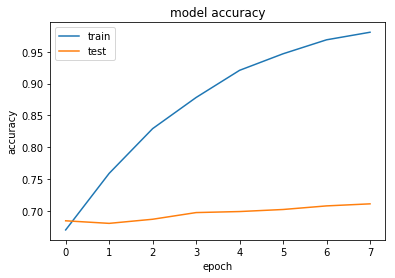

In [4]:
import itertools

considered_widths = [
    [10, 50, 10],
    [100, 100],
    [100, 200, 100]
]

for widths in considered_widths:
    print('Testing simple model with layers: {}'.format(widths))
    filename = network_name('dense_' + '_'.join([str(w) for w in widths]))
    simple_trained = tester.test_model(simple_network(widths), max_epochs=50)
    # Dense networks have very poor results and easly overfit - we disable saving them
    #simple_trained.save(filename)

Test convolutional network with parameters {'pool': 16, 'layers': [(4, 16), (16, 16)]}:
Trained for 35 epochs
loss: 0.3749, binary_accuracy: 0.8084, mean_squared_error: 0.1237, precision: 0.6339, recall: 0.8686, fmeasure: 0.7197
Trained for 35 epochs
loss: 0.3659, binary_accuracy: 0.8510, mean_squared_error: 0.1138, precision: 0.7004, recall: 0.7922, fmeasure: 0.7354
Trained for 36 epochs
loss: 0.3418, binary_accuracy: 0.8567, mean_squared_error: 0.1029, precision: 0.8906, recall: 0.5796, fmeasure: 0.6875
Trained for 23 epochs
loss: 0.4394, binary_accuracy: 0.8152, mean_squared_error: 0.1360, precision: 0.9048, recall: 0.4567, fmeasure: 0.5787
Trained for 15 epochs
loss: 0.3556, binary_accuracy: 0.8571, mean_squared_error: 0.1115, precision: 0.6851, recall: 0.7597, fmeasure: 0.7128
loss: 0.3755 (+/-0.0338), binary_accuracy: 0.8377 (+/-0.0214), mean_squared_error: 0.1176 (+/-0.0113), precision: 0.7630 (+/-0.1123), recall: 0.6914 (+/-0.1509), fmeasure: 0.6868 (+/-0.0562)


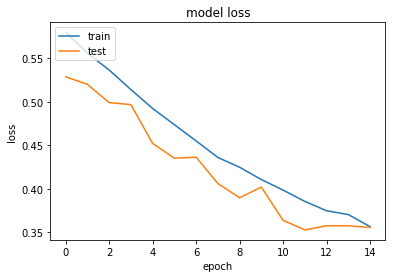

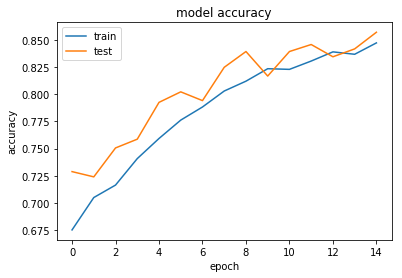

Test convolutional network with parameters {'pool': 16, 'layers': [(32, 16), (16, 16)]}:
Trained for 27 epochs
loss: 0.3137, binary_accuracy: 0.8663, mean_squared_error: 0.0966, precision: 0.7986, recall: 0.7738, fmeasure: 0.7786
Trained for 15 epochs
loss: 0.4062, binary_accuracy: 0.8060, mean_squared_error: 0.1321, precision: 0.6263, recall: 0.8013, fmeasure: 0.6971
Trained for 28 epochs
loss: 0.2978, binary_accuracy: 0.8953, mean_squared_error: 0.0854, precision: 0.8798, recall: 0.7699, fmeasure: 0.8105
Trained for 27 epochs
loss: 0.3178, binary_accuracy: 0.8701, mean_squared_error: 0.0987, precision: 0.7674, recall: 0.8226, fmeasure: 0.7794
Trained for 22 epochs
loss: 0.2952, binary_accuracy: 0.8797, mean_squared_error: 0.0899, precision: 0.8507, recall: 0.5981, fmeasure: 0.6921
loss: 0.3261 (+/-0.0410), binary_accuracy: 0.8635 (+/-0.0305), mean_squared_error: 0.1005 (+/-0.0165), precision: 0.7846 (+/-0.0883), recall: 0.7532 (+/-0.0799), fmeasure: 0.7515 (+/-0.0479)


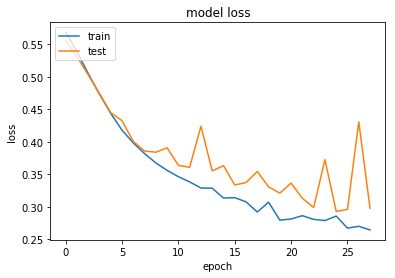

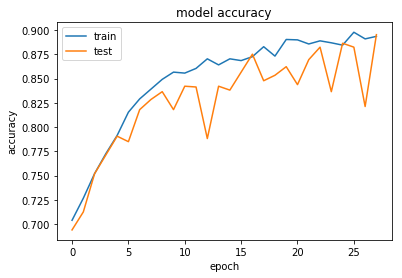

Test convolutional network with parameters {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]}:
Trained for 10 epochs
loss: 0.4569, binary_accuracy: 0.7810, mean_squared_error: 0.1507, precision: 0.6879, recall: 0.5757, fmeasure: 0.6063
Trained for 21 epochs
loss: 0.3745, binary_accuracy: 0.8309, mean_squared_error: 0.1185, precision: 0.8889, recall: 0.5394, fmeasure: 0.6607
Trained for 20 epochs
loss: 0.5148, binary_accuracy: 0.7359, mean_squared_error: 0.1694, precision: 0.5812, recall: 0.5947, fmeasure: 0.5648
Trained for 22 epochs
loss: 0.3771, binary_accuracy: 0.8362, mean_squared_error: 0.1210, precision: 0.9317, recall: 0.5143, fmeasure: 0.6420
Trained for 24 epochs
loss: 0.3578, binary_accuracy: 0.8337, mean_squared_error: 0.1139, precision: 0.7287, recall: 0.5496, fmeasure: 0.6142
loss: 0.4162 (+/-0.0601), binary_accuracy: 0.8035 (+/-0.0395), mean_squared_error: 0.1347 (+/-0.0216), precision: 0.7637 (+/-0.1297), recall: 0.5548 (+/-0.0280), fmeasure: 0.6176 (+/-0.0328)


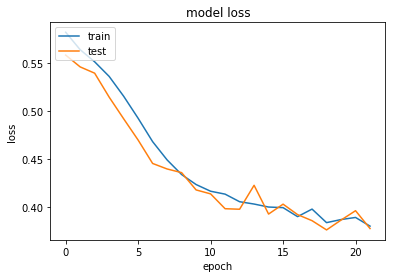

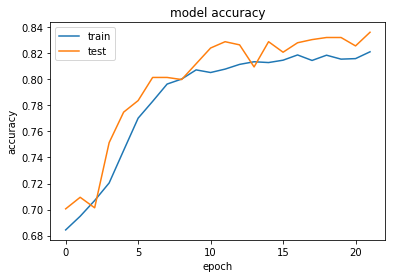

In [5]:
considered_variants = [
    {'pool': 16, 'layers': [(4, 16), (16, 16)]},
    {'pool': 16, 'layers': [(32, 16), (16, 16)]},
    {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]},
]

for i, variant in enumerate(considered_variants):
    print("Test convolutional network with parameters {}:".format(variant))
    filename = network_name('conv_' + str(i))
    trained = tester.test_model(conv_network(**variant), max_epochs=50)
    trained.save(filename)